In [33]:
import pydicom
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, HBox, Output
from scipy.ndimage import map_coordinates
from scipy.ndimage import convolve as scipy_convolve 
import nibabel as nib 
import matplotlib.colors as mcolors

# Actividad 1: Manipulación de imágenes, DICOM y color

**Nombre:** Maximiliano Antonio Gaete Pizarro

**RUT:** 21.320.154-9

In [34]:
data_dir_1 = './Tarea_1/datos/data_1'
output_csv_data_1 = 'patient_info_data1.csv'
output_data_1_anon = './Tarea_1/datos/data_1_anon'

data_dir_2 = './Tarea_1/datos/data_2'

p5_filepath = './Tarea_1/datos/p5.dcm'
xray_filepath = './Tarea_1/datos/xray.dcm'

anat_filepath = './Tarea_1/datos/anat.nii'
zmap_voice_filepath = './Tarea_1/datos/zmap_voice.nii'
zmap_nonvoice_filepath = './Tarea_1/datos/zmap_nonvoice.nii'

### 3.1 Extracción de Información de Pacientes (data_1)

los archivos DICOM del directorio `data_1`. De cada archivo, extraemos el nombre del paciente y su fecha de nacimiento. Luego, guardamos esta información en un archivo CSV para tenerla ordenada.

In [35]:
patient_data = []

for filename in os.listdir(data_dir_1):

    filepath = os.path.join(data_dir_1, filename)

    if os.path.isfile(filepath):
        ds = pydicom.dcmread(filepath, force=True)

        patient_name = ds.get('PatientName', 'N/A') # Nombre
        birth_date = ds.get('PatientBirthDate', 'N/A') # Cumpleaños

        # Formatear la fecha de nacimiento si tiene el formato YYYYMMDD
        if isinstance(birth_date, str) and len(birth_date) == 8 and birth_date.isdigit():
            birth_date_fmt = f"{birth_date[:4]}-{birth_date[4:6]}-{birth_date[6:]}"
        else:
            birth_date_fmt = birth_date

        # Añadir los datos a una lista
        patient_data.append([patient_name, birth_date_fmt])
        print(f"Nombre: {patient_name}, Cumpleaños: {birth_date_fmt}")

total_pacientes = len(patient_data)
print(f"Total de pacientes procesados: {total_pacientes}")

if patient_data: # Solo escribir si se encontraron datos
    with open(output_csv_data_1, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        # Escribir la cabecera
        writer.writerow(['PatientName', 'PatientBirthDate'])
        # Escribir los datos de los pacientes
        writer.writerows(patient_data)
        print(f"Datos escritos en {output_csv_data_1}")

Nombre: Débora Salas, Cumpleaños: 1977-05-08
Nombre: Luis Chabert, Cumpleaños: 1983-02-08
Nombre: Alejandro Chabert, Cumpleaños: 1979-10-01
Nombre: Cesar Buendía, Cumpleaños: 1983-07-29
Nombre: Germán Roncagliolo, Cumpleaños: 1977-05-13
Nombre: Pablo Roncagliolo, Cumpleaños: 1983-02-02
Nombre: Germán Salas, Cumpleaños: 1985-02-04
Nombre: Pablo Buendía, Cumpleaños: 1985-09-15
Nombre: Wael Veloz, Cumpleaños: 1977-07-20
Nombre: Germán Buendía, Cumpleaños: 1983-04-04
Nombre: Wael Veloz, Cumpleaños: 1985-01-14
Nombre: Wael Weinstein, Cumpleaños: 1979-05-04
Nombre: Wael Salas, Cumpleaños: 1975-10-19
Nombre: Steren Veloz, Cumpleaños: 1985-11-17
Nombre: Scarlett Salas, Cumpleaños: 1979-01-18
Nombre: Germán Weinstein, Cumpleaños: 1977-11-20
Nombre: Luis Veloz, Cumpleaños: 1979-09-23
Nombre: Débora Chabert, Cumpleaños: 1981-09-13
Nombre: Germán Lever, Cumpleaños: 1985-01-03
Nombre: Germán Buendía, Cumpleaños: 1985-04-01
Total de pacientes procesados: 20
Datos escritos en patient_info_data1.csv


## 3.2

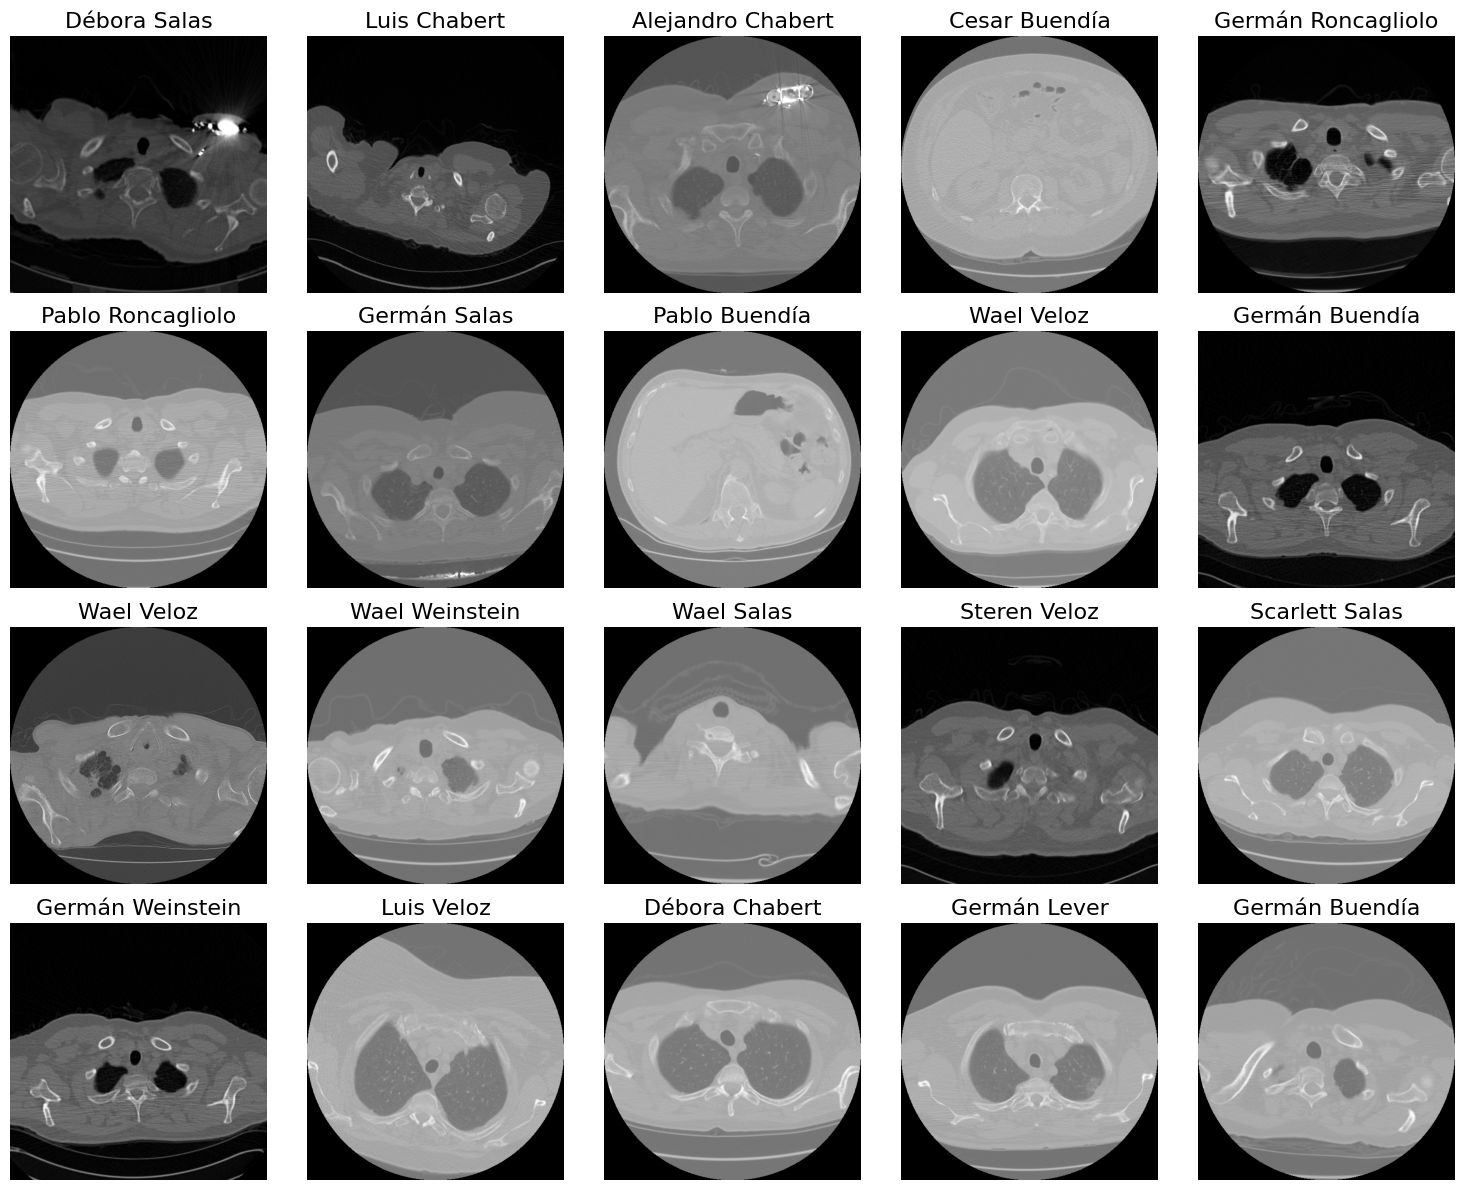

In [36]:

dicom_files = []

for filename in os.listdir(data_dir_1):

    filepath = os.path.join(data_dir_1, filename)

    if os.path.isfile(filepath):

        dicom_files.append(filepath)

# leer
valid_datasets = []
patient_names = []

for filepath in dicom_files:

    ds = pydicom.dcmread(filepath) # lee pixeles


    if 'PixelData' in ds:

        patient_name_tag = ds.get('PatientName', 'Nombre Desconocido')
        if isinstance(patient_name_tag, pydicom.valuerep.PersonName):
            patient_name = str(patient_name_tag)

        valid_datasets.append(ds)
        patient_names.append(patient_name)


if valid_datasets:

    # dimensiones
    num_images = len(valid_datasets)

    cols = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3)) # Ajusta el tamaño por subplot

    axes = axes.ravel()

    # Iterar sobre los datasets DICOM válidos y mostrarlos
    for i, ds in enumerate(valid_datasets):

        axes[i].imshow(ds.pixel_array, cmap=plt.cm.gray)
        # nombre del paciente
        axes[i].set_title(patient_names[i], fontsize=16)
        axes[i].axis('off')

    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

### 3.3 Anonimización de Datos (data_1_anon)

Para proteger la privacidad de los pacientes, es importante anonimizar los datos antes de compartirlos o usarlos en investigaciones.

In [37]:
# directorio de salida 
if not os.path.exists(output_data_1_anon):
    os.makedirs(output_data_1_anon)
    print(f"Directorio '{output_data_1_anon}' creado.")

# Campos DICOM comunes que suelen contener información personal
tags_to_anonymize = [
    "PatientName",
    "PatientID",
    "PatientBirthDate",
    "PatientSex",
    "PatientAge",
    "PatientAddress",
    "PatientTelephoneNumbers",
]


for filename in os.listdir(data_dir_1):
    filepath = os.path.join(data_dir_1, filename)
    
    if os.path.isfile(filepath) and filename.lower().endswith('.dcm'):
        # Leemos el archivo DICOM
        ds = pydicom.dcmread(filepath)
        
        # Iteramos sobre las etiquetas 
        for tag_name in tags_to_anonymize:
            if tag_name in ds:

                tag_element = ds.data_element(tag_name)
                if tag_element: 
                    tag_element.value = "" # reemplazar por vacío
        
        ds.SOPInstanceUID = pydicom.uid.generate_uid()

        #  ruta de salida
        output_filepath = os.path.join(output_data_1_anon, filename)
        
        ds.save_as(output_filepath)
        print(f"Archivo DICOM anonimizado guardado como: {output_filepath}")

        # Imprimir solo un resumen de los datos anonimizados (nombre y fecha de nacimiento)
        for filename in os.listdir(output_data_1_anon):
            filepath = os.path.join(output_data_1_anon, filename)
            if os.path.isfile(filepath) and filename.lower().endswith('.dcm'):
                ds = pydicom.dcmread(filepath)
                nombre = ds.get("PatientName", "N/A")
                fecha = ds.get("PatientBirthDate", "N/A")
                print(f"{filename}: Name='{nombre}', BirthDate='{fecha}'")


Archivo DICOM anonimizado guardado como: ./Tarea_1/datos/data_1_anon\019787df3ae203ec160fb86dbee9275b.dcm
019787df3ae203ec160fb86dbee9275b.dcm: Name='', BirthDate=''
121969a3ea1dcd63ea14b7c8754098d3.dcm: Name='', BirthDate=''
16e2678d2ea8d8638f69a6f7b54eb030.dcm: Name='', BirthDate=''
22b3866a120110dde0ed9bfd73088e93.dcm: Name='', BirthDate=''
24cdd17911455e15811b3a330d625ce9.dcm: Name='', BirthDate=''
3d5a32fc7bc51b8c88ad46cce0354520.dcm: Name='', BirthDate=''
50cda0fb366c8e4b30766b3a435c3a40.dcm: Name='', BirthDate=''
53494c16c19ddf12a01ee4affd2a3181.dcm: Name='', BirthDate=''
5b5a722e6da741943f0f761ec4b4d7ec.dcm: Name='', BirthDate=''
6b9959c342ad8cc56e42e2e3905424d4.dcm: Name='', BirthDate=''
6c1e91d0076333f589467bfc3e6172e8.dcm: Name='', BirthDate=''
7510e0ae9b42ae60be15409c64cb0144.dcm: Name='', BirthDate=''
9a1e70e7253f1efb1b8dc8ce83c50f45.dcm: Name='', BirthDate=''
9df7456ff748c9bbd232119ce2f54797.dcm: Name='', BirthDate=''
b4e8448cdde20e3d0b590ebfb0af3039.dcm: Name='', BirthDa

### 3.4 Carga y Visualización Interactiva de Volumen 3D (data_2)

Ahora trabajamos con el conjunto de datos `data_2`. Estos archivos DICOM representan cortes axiales que forman un volumen 3D. Los cargamos, ordenamos y los apilamos para formar una matriz 3D con NumPy.

Para entender mejor la anatomía, visualizamos este volumen desde diferentes perspectivas usando `matplotlib` y `ipywidgets`.

In [38]:
def cargar_y_preparar_dicom(directorio):

    archivos = [os.path.join(directorio, f) for f in os.listdir(directorio) if f.lower().endswith('.dcm')]
    datasets = [pydicom.dcmread(p) for p in archivos]
    datasets.sort(key=lambda ds: int(ds.InstanceNumber))
    volumen = np.stack([ds.pixel_array for ds in datasets])
    print(f"Volumen 3D de {volumen.shape} cargado.")
    return volumen

def mostrar_vistas(volumen, x, y, z):

    corte_axial = volumen[z, :, :]
    corte_coronal = volumen[:, y, :]
    corte_sagital = volumen[:, :, x]
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].set_title(f'Axial (Z={z})')
    axes[0].imshow(corte_axial, cmap='gray', aspect='auto') 

    axes[1].set_title(f'Coronal (Y={y})')
    axes[1].imshow(corte_coronal, cmap='gray', aspect='auto') 

    axes[2].set_title(f'Sagital (X={x})')
    axes[2].imshow(corte_sagital, cmap='gray', aspect='auto') 

    plt.tight_layout()
    plt.show()


volume_3d = cargar_y_preparar_dicom(data_dir_2)

if volume_3d is not None:
    Z, Y, X = volume_3d.shape
    
    interact(
        lambda x, y, z: mostrar_vistas(volume_3d, x, y, z),
        x=IntSlider(min=0, max=X-1, value=X//2, description='Corte X:'),
        y=IntSlider(min=0, max=Y-1, value=Y//2, description='Corte Y:'),
        z=IntSlider(min=0, max=Z-1, value=Z//2, description='Corte Z:')
    )

Volumen 3D de (110, 512, 512) cargado.


interactive(children=(IntSlider(value=256, description='Corte X:', max=511), IntSlider(value=256, description=…

### 3.5 Corte Oblicuo 

Además de los cortes estándar, podemos generar cortes en ángulos arbitrarios (oblicuos). Definimos una función que, dado un ángulo de rotación alrededor del eje Z y un desplazamiento, calcula las coordenadas del plano oblicuo e interpola los valores de los píxeles del volumen 3D original usando `scipy.ndimage.map_coordinates`. Usamos `ipywidgets` para controlar interactivamente el ángulo y el desplazamiento.

In [39]:
if volume_3d is not None:

    depth, height, width = volume_3d.shape  # Z, Y, X

    def ver_corte_oblicuo(angulo_grados, offset_plano):

        angulo_rad = np.deg2rad(angulo_grados)
        
        # Centro de la imagen 
        centro_x, centro_y = width // 2, height // 2
        
        # Crea una grilla de coordenadas para el nuevo plano oblicuo
        # La altura del nuevo plano es la profundidad (Z) del volumen
        # El ancho (S) se calcula para cubrir la diagonal del plano XY
        max_s = int(np.sqrt(width**2 + height**2))
        coords_z, coords_s = np.mgrid[0:depth, -max_s//2 : max_s//2]

        # Calcula las coordenadas (X, Y) en el volumen original para cada punto del plano oblicuo
        # Esta es la fórmula de rotación de coordenadas
        x_vol = coords_s * np.cos(angulo_rad) + centro_x + offset_plano * np.sin(angulo_rad)
        y_vol = -coords_s * np.sin(angulo_rad) + centro_y + offset_plano * np.cos(angulo_rad)
        
        # Apila las coordenadas para la interpolación [Z, Y, X]
        coords_vol = np.stack([coords_z.ravel(), y_vol.ravel(), x_vol.ravel()])
        
        # Interpola los valores del volumen original en las nuevas coordenadas
        corte_oblicuo_flat = map_coordinates(volume_3d, coords_vol, order=1, mode='nearest')
        corte_oblicuo = corte_oblicuo_flat.reshape(coords_z.shape)

        plt.figure(figsize=(9, 9))
        
        plt.imshow(corte_oblicuo.T, cmap='gray', aspect='auto') 
        
        plt.title(f'Corte Oblicuo (Ángulo = {angulo_grados}°, Offset = {offset_plano})')
        plt.xlabel("Eje de corte (rotado en el plano XY)")
        plt.ylabel("Eje Z (Profundidad)")
        plt.gca().invert_yaxis() 
        plt.show()

    offset_max = max(width, height) // 3
    
    interact(ver_corte_oblicuo,
             angulo_grados=FloatSlider(min=0, max=180, step=5, value=45, description='Ángulo:'),
             offset_plano=IntSlider(min=-offset_max, max=offset_max, step=5, value=0, description='Offset:'))


interactive(children=(FloatSlider(value=45.0, description='Ángulo:', max=180.0, step=5.0), IntSlider(value=0, …

### 3.6 Downsampling (Submuestreo)

El submuestreo es una técnica útil para reducir el tamaño de las imágenes, aunque puede implicar pérdida de detalle. Aquí cargamos la imagen `p5.dcm` y creamos una versión reducida tomando uno de cada cuatro píxeles en ambas direcciones (horizontal y vertical). Comparamos visualmente la imagen original con la submuestreada.

Imagen p5.dcm cargada. Dimensiones originales: (512, 512)
Dimensiones después de downsampling (1 de cada 4): (128, 128)


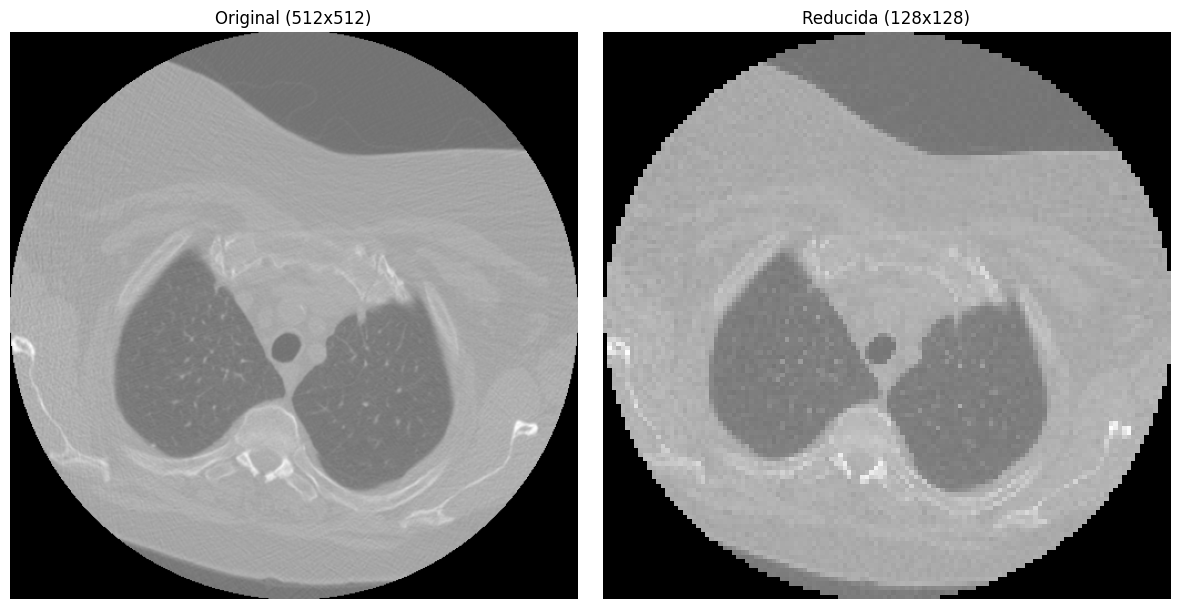

In [40]:
ds_p5 = pydicom.dcmread(p5_filepath)
img_p5_original = ds_p5.pixel_array
print(f"Imagen {os.path.basename(p5_filepath)} cargada. Dimensiones originales: {img_p5_original.shape}")

# Proceso de Downsampling 
img_p5_downsampled = img_p5_original[::4, ::4]
print(f"Dimensiones después de downsampling (1 de cada 4): {img_p5_downsampled.shape}")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_p5_original, cmap='gray')
axes[0].set_title(f'Original ({img_p5_original.shape[0]}x{img_p5_original.shape[1]})')
axes[0].axis('off') 

axes[1].imshow(img_p5_downsampled, cmap='gray')
axes[1].set_title(f'Reducida ({img_p5_downsampled.shape[0]}x{img_p5_downsampled.shape[1]})')
axes[1].axis('off')

plt.tight_layout() 
plt.show()

Resolución y Tamaño: La diferencia más evidente es la drástica reducción en la resolución. La imagen original de 512x512 píxeles (262,144 píxeles en total) se convierte en una imagen de 128x128 píxeles (16,384 píxeles). Esto significa que la nueva imagen contiene solo el 6.25% (1/16) de la información de la original, ocupando mucho menos espacio en memoria o disco.

Pérdida de Detalle y Nitidez: Al descartar 3 de cada 4 píxeles, se pierde una cantidad significativa de información de alta frecuencia. Esto se traduce en una notable pérdida de detalle. Estructuras pequeñas, bordes finos y texturas sutiles que eran visibles en la imagen original desaparecen o se vuelven borrosas en la versión reducida. La imagen resultante es una representación mucho más "gruesa" y menos precisa de la anatomía.

Efecto de "Pixelación" y Aliasing: Si se ampliara la imagen reducida para que tuviera el mismo tamaño visual que la original, se notaría un efecto de "pixelación" o "bloques". Además, este método simple de submuestreo (descartar píxeles) puede introducir un artefacto conocido como aliasing, donde patrones finos o líneas delgadas de la imagen original pueden ser malinterpretados o desaparecer por completo si no caen exactamente en la nueva grilla de muestreo.

### 3.7 Mejora de Contraste Interactivo

Para mejorar la visualización de detalles en las imágenes DICOM, aplicamos dos técnicas comunes de mejora de contraste a un corte axial seleccionado: la transformación Gamma (ley de potencia) y la transformación lineal por tramos (estiramiento de contraste). Creamos controles interactivos para ajustar los parámetros (gamma, r1, s1, r2, s2) y ver el efecto en la imagen y su histograma en tiempo real.

In [41]:
def cargar_volumen_dicom(directorio):
    """Carga los archivos DICOM y los apila en un volumen 3D."""
    try:
        archivos = [os.path.join(directorio, f) for f in os.listdir(directorio) if f.lower().endswith('.dcm')]
        datasets = [pydicom.dcmread(p) for p in archivos]
        datasets.sort(key=lambda ds: int(ds.InstanceNumber))
        volumen = np.stack([ds.pixel_array for ds in datasets])
        print(f"Volumen 3D de {volumen.shape} cargado correctamente.")
        return volumen
    except Exception as e:
        print(f"No se pudo cargar la serie DICOM: {e}")
        return None

volume_3d = cargar_volumen_dicom(data_dir_2)

# Si el volumen se cargó, preparamos la interfaz interactiva
if volume_3d is not None:
    depth, height, width = volume_3d.shape

    # --- Funciones de Transformación (Tu código, que está excelente) ---
    def transformacion_gamma(imagen, gamma, c=1.0):
        img_float = imagen.astype(np.float64)
        min_val, max_val = np.min(img_float), np.max(img_float)
        rango = max_val - min_val
        if rango == 0: return imagen
        img_norm = (img_float - min_val) / rango
        img_gamma_norm = c * np.power(img_norm, gamma)
        img_transformada = (img_gamma_norm * rango) + min_val
        return img_transformada.astype(imagen.dtype)

    def transformacion_lineal_tramos(imagen, r1, s1, r2, s2):
        if r1 >= r2: return imagen
        img_float = imagen.astype(np.float64)
        img_transformada = np.zeros_like(img_float)
        
        m1 = s1 / r1 if r1 > 0 else 0
        m2 = (s2 - s1) / (r2 - r1)
        m3 = (np.max(img_float) - s2) / (np.max(img_float) - r2) if np.max(img_float) > r2 else 0
        
        mask1 = img_float < r1
        mask2 = (img_float >= r1) & (img_float <= r2)
        mask3 = img_float > r2
        
        img_transformada[mask1] = m1 * img_float[mask1]
        img_transformada[mask2] = m2 * (img_float[mask2] - r1) + s1
        img_transformada[mask3] = m3 * (img_float[mask3] - r2) + s2
        
        return np.clip(img_transformada, np.min(imagen), np.max(imagen)).astype(imagen.dtype)

    # --- Creación de Widgets ---
    min_intensidad, max_intensidad = int(np.min(volume_3d)), int(np.max(volume_3d))

    slider_corte_z = IntSlider(min=0, max=depth-1, value=depth//2, description='Corte Z:')
    dropdown_transform = Dropdown(options=['Original', 'Gamma', 'Lineal por Tramos'], value='Original', description='Mejora:')
    slider_gamma = FloatSlider(min=0.1, max=5.0, step=0.1, value=1.0, description='Gamma (γ):', disabled=True)
    
    slider_r1 = IntSlider(min=min_intensidad, max=max_intensidad, value=max_intensidad//4, description='r1:')
    slider_s1 = IntSlider(min=min_intensidad, max=max_intensidad, value=min_intensidad, description='s1:')
    slider_r2 = IntSlider(min=min_intensidad, max=max_intensidad, value=3*max_intensidad//4, description='r2:')
    slider_s2 = IntSlider(min=min_intensidad, max=max_intensidad, value=max_intensidad, description='s2:')
    
    widgets_gamma = HBox([slider_gamma])
    widgets_lineal = VBox([HBox([slider_r1, slider_s1]), HBox([slider_r2, slider_s2])])
    area_salida = Output()

    def manejar_visibilidad_params(cambio):
        tipo = cambio['new']
        slider_gamma.disabled = (tipo != 'Gamma')
        for w in widgets_lineal.children: w.disabled = (tipo != 'Lineal por Tramos')
        actualizar_graficas(None)

    def actualizar_graficas(_):
        with area_salida:
            area_salida.clear_output(wait=True)
            idx_z, tipo_mejora = slider_corte_z.value, dropdown_transform.value
            corte_original = volume_3d[idx_z, :, :]
            
            if tipo_mejora == 'Gamma':
                corte_mejorado = transformacion_gamma(corte_original, slider_gamma.value)
                titulo_mejora = f"Gamma (γ={slider_gamma.value:.1f})"
            elif tipo_mejora == 'Lineal por Tramos' and slider_r1.value < slider_r2.value:
                corte_mejorado = transformacion_lineal_tramos(corte_original, slider_r1.value, slider_s1.value, slider_r2.value, slider_s2.value)
                titulo_mejora = "Lineal por Tramos"
            else:
                corte_mejorado = corte_original
                titulo_mejora = "Original"

            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # Imagen Original e Histograma
            axes[0, 0].imshow(corte_original, cmap='gray', aspect='auto')
            axes[0, 0].set_title(f'Corte {idx_z} - Original')
            axes[0, 0].axis('off')
            axes[1, 0].hist(corte_original.ravel(), bins=128, range=(min_intensidad, max_intensidad), color='royalblue')
            axes[1, 0].set_title('Histograma Original')
            
            # Imagen Mejorada e Histograma
            axes[0, 1].imshow(corte_mejorado, cmap='gray', aspect='auto')
            axes[0, 1].set_title(f'Corte {idx_z} - {titulo_mejora}')
            axes[0, 1].axis('off')
            axes[1, 1].hist(corte_mejorado.ravel(), bins=128, range=(min_intensidad, max_intensidad), color='coral')
            axes[1, 1].set_title(f'Histograma {titulo_mejora}')
            
            plt.tight_layout()
            plt.show()

    # Conectar widgets a funciones
    dropdown_transform.observe(manejar_visibilidad_params, names='value')
    for control in [slider_corte_z, slider_gamma, slider_r1, slider_s1, slider_r2, slider_s2]:
        control.observe(actualizar_graficas, names='value')

    # Mostrar la interfaz y dibujar el estado inicial
    display(VBox([slider_corte_z, dropdown_transform, widgets_gamma, widgets_lineal, area_salida]))
    manejar_visibilidad_params({'new': dropdown_transform.value})

Volumen 3D de (110, 512, 512) cargado correctamente.


1. Transformación Gamma (Corrección de Potencia)
Esta técnica modifica la luminosidad de la imagen de forma no lineal. El resultado depende del valor de gamma (γ).

El contraste MEJORA cuando:

Se usa un γ<1 (ej. 0.4): Esta transformación "levanta" las sombras. Expande los rangos de intensidad oscuros y comprime los rangos claros. Es ideal para imágenes oscuras donde los detalles importantes están en las zonas de baja intensidad. Se mejora la visibilidad en las áreas sombrías, aunque se corre el riesgo de "quemar" (perder detalle) las zonas que ya eran brillantes.
Se usa un γ>1 (ej. 2.5): Esta transformación oscurece la imagen, expandiendo los rangos de intensidad altos y comprimiendo los oscuros. Es útil en imágenes muy brillantes o "lavadas", donde los detalles se pierden por exceso de luz. Permite recuperar información en zonas casi blancas, a costa de perderla en las zonas oscuras.
El contraste EMPEORA cuando:

Se aplica un valor de gamma incorrecto para la imagen. Por ejemplo, usar un γ>1 en una imagen que ya es oscura la hará prácticamente negra, perdiendo casi toda la información.
Usar un γ<1 en una imagen muy brillante la "quemará" por completo, resultando en una gran mancha blanca sin detalles.
2. Transformación Lineal por Tramos (Estiramiento de Contraste)
Esta técnica permite un control mucho más preciso, al "estirar" un rango específico de intensidades que nos interesa.

El contraste MEJORA cuando:

Se identifica un rango de intensidades de interés [r1, r2] (por ejemplo, los valores de un tejido blando específico) que en la imagen original se ve muy plano o con poco contraste.
Se mapea este rango a un rango de salida [s1, s2] que es más amplio (es decir, la pendiente (s2-s1)/(r2-r1) es mayor que 1).
Esto "estira" el histograma en esa zona, haciendo que diferencias sutiles de gris se vuelvan mucho más notorias. Es la técnica más poderosa para realzar características específicas.
El contraste EMPEORA cuando:

La pendiente del tramo central es menor que 1. Esto significa que estamos comprimiendo un rango de intensidades, reduciendo su contraste y perdiendo detalles en esa zona.
Se elige un rango [r1, r2] que no contiene información relevante. En este caso, estaremos amplificando ruido o zonas homogéneas, sin ninguna mejora real.
Los valores de los puntos se eligen de manera que se "recorta" información (por ejemplo, haciendo que s1 y s2 sean muy parecidos), lo que resulta en una imagen con menos niveles de gris y apariencia posterizada.


Personalmente me gusta cuando los rangos de [r1, r2] toman valores de [0 , 500] o [500 a 1500] y se expande al histograma ya que resalta mucho la imagen y se ven cosas que antes no eran apreciables :)

### 3.8 Implementacion de la ecualización (Ec. 3.3-8, página 126) y especificación de histogramas (Ec. 3.3-12, página 130). 

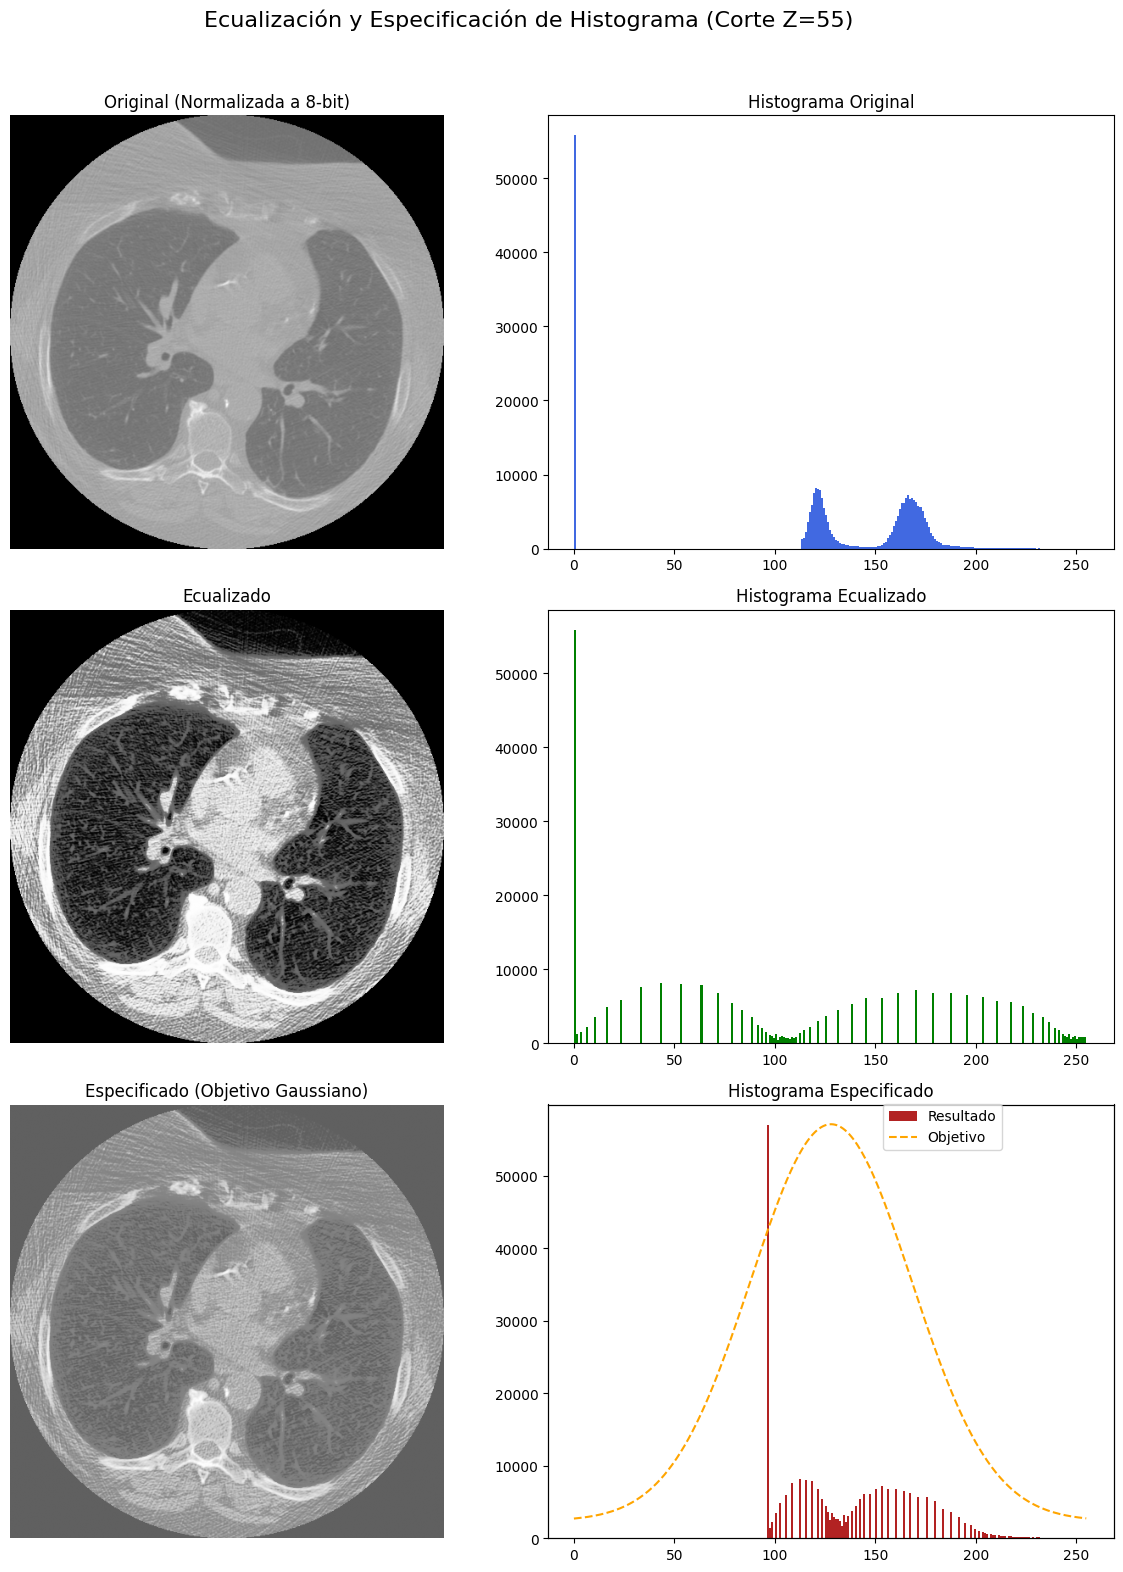

In [42]:
if volume_3d is not None:
    depth, height, width = volume_3d.shape
    
    idx_corte_hist = depth // 2
    corte_original_hist = volume_3d[idx_corte_hist, :, :].copy()

    def ecualizar_histograma(imagen):
        """Ecualiza el histograma de una imagen usando la fórmula CDF."""

        hist, bin_edges = np.histogram(imagen.flatten(), bins=256, range=[np.min(imagen), np.max(imagen)])
        cdf = hist.cumsum()
        
        cdf_mascara = np.ma.masked_equal(cdf, 0)
        cdf_mapeo = (cdf_mascara - cdf_mascara.min()) * 255 / (cdf_mascara.max() - cdf_mascara.min())
        cdf_final = np.ma.filled(cdf_mapeo, 0).astype('uint8') 
        
        imagen_ecualizada = cdf_final[imagen]
        return imagen_ecualizada

    def especificar_histograma(imagen, hist_objetivo):
        """Especifica el histograma de 'imagen' para que se parezca a 'hist_objetivo'."""

        hist_imagen, _ = np.histogram(imagen.flatten(), bins=256, range=[0, 255])
        cdf_imagen = hist_imagen.cumsum()
        cdf_imagen_norm = cdf_imagen / float(cdf_imagen.max())


        cdf_objetivo = hist_objetivo.cumsum()
        cdf_objetivo_norm = cdf_objetivo / float(cdf_objetivo.max())


        mapeo = np.zeros(256)
        for i in range(256):
            j = np.argmin(np.abs(cdf_imagen_norm[i] - cdf_objetivo_norm))
            mapeo[i] = j
        
        return mapeo[imagen].astype('uint8')

    img_norm = ((corte_original_hist - np.min(corte_original_hist)) / (np.max(corte_original_hist) - np.min(corte_original_hist)) * 255).astype(np.uint8)

    corte_ecualizado = ecualizar_histograma(img_norm)

    niveles = np.arange(256)
    media_objetivo, std_dev_objetivo = 128, 40
    pdf_gaussiano = np.exp(-((niveles - media_objetivo)**2) / (2 * std_dev_objetivo**2))
    
    corte_especificado = especificar_histograma(img_norm, pdf_gaussiano)

    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    fig.suptitle(f'Ecualización y Especificación de Histograma (Corte Z={idx_corte_hist})', fontsize=16)

    # Original
    axes[0, 0].imshow(img_norm, cmap='gray', vmin=0, vmax=255)
    axes[0, 0].set_title('Original (Normalizada a 8-bit)')
    axes[0, 0].axis('off')
    axes[0, 1].hist(img_norm.ravel(), bins=256, range=[0, 256], color='royalblue')
    axes[0, 1].set_title('Histograma Original')

    # Ecualizado
    axes[1, 0].imshow(corte_ecualizado, cmap='gray', vmin=0, vmax=255)
    axes[1, 0].set_title('Ecualizado')
    axes[1, 0].axis('off')
    axes[1, 1].hist(corte_ecualizado.ravel(), bins=256, range=[0, 256], color='green')
    axes[1, 1].set_title('Histograma Ecualizado')

    # Especificado
    axes[2, 0].imshow(corte_especificado, cmap='gray', vmin=0, vmax=255)
    axes[2, 0].set_title('Especificado (Objetivo Gaussiano)')
    axes[2, 0].axis('off')
    axes[2, 1].hist(corte_especificado.ravel(), bins=256, range=[0, 256], color='firebrick', label='Resultado')
    axes[2, 1].set_title('Histograma Especificado')
    
    ax2 = axes[2, 1].twinx()
    ax2.plot(niveles, pdf_gaussiano, color='orange', linestyle='--', label='Objetivo')
    ax2.set_yticks([])
    
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.3))
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

1. Ecualización de Histograma
La ecualización es un método automático que busca mejorar el contraste global de una imagen.

¿Qué hace? Su objetivo es redistribuir los niveles de intensidad de los píxeles para que el histograma de la imagen resultante sea lo más plano posible. En teoría, esto significa que cada nivel de gris tendría la misma cantidad de píxeles. En la práctica, "estira" los rangos de intensidad más poblados para que ocupen una porción mayor del espectro total.
Resultado Visual: Como se ve en la imagen "Ecualizado", el contraste general aumenta considerablemente. Las zonas que en la imagen original eran una masa de grises similares (como se ve en el peak del histograma original) ahora muestran muchos más detalles y texturas. El histograma resultante está mucho más distribuido, cubriendo todo el rango de intensidades de manera más uniforme.
Conclusión: Es una técnica muy efectiva para realzar el contraste de forma rápida y sin necesidad de parámetros. Su principal desventaja es que puede amplificar el ruido de fondo y, en ocasiones, generar un contraste que parece poco natural, precisamente porque trata a todos los píxeles por igual.

2. Especificación de Histograma (Histogram Matching)
La especificación es una técnica más controlada y potente que la ecualización.

¿Qué hace? En lugar de buscar un histograma plano, esta técnica transforma la imagen para que su histograma se parezca lo más posible a una forma predefinida por el usuario. En nuestro caso, le pedimos que el histograma resultante siga una curva Gaussiana (una campana).
Resultado Visual: La imagen "Especificado" tiene un contraste que parece más natural que la ecualizada. El histograma resultante imita la forma de campana que le dimos como objetivo. Esto significa que la mayoría de los píxeles se concentran en los tonos medios de gris, con una transición suave hacia los negros y los blancos, similar a como ocurre en muchas fotografías.
Conclusión: Esta técnica ofrece un control total sobre la apariencia final de la imagen. Es superior a la ecualización cuando se busca un resultado específico o cuando la ecualización produce artefactos no deseados. Su poder radica en la capacidad de definir la distribución de tonos exacta que se quiere conseguir.

## 3.2.1 Filtrado Espacial

El filtrado espacial es una técnica fundamental en el procesamiento de imágenes que opera directamente sobre los píxeles de una imagen. Consiste en aplicar una operación (generalmente una convolución con un kernel o máscara) a la vecindad de cada píxel para obtener un nuevo valor para ese píxel en la imagen resultante.

Los objetivos comunes del filtrado espacial incluyen:
* **Reducción de ruido:** Suavizar la imagen para atenuar variaciones aleatorias de intensidad (ej. filtros promedio, Gaussiano, mediana).
* **Realce de bordes:** Detectar y resaltar cambios bruscos de intensidad, que usualmente corresponden a bordes de objetos (ej. filtros Sobel, Laplaciano).

En esta sección, implementaremos manualmente (sin usar librerías específicas de PDI como `scipy.ndimage` o `opencv` para la convolución o filtros predefinidos) los siguientes filtros:
1.  **Filtro Promedio (Average Filter):** Un filtro lineal simple que reemplaza cada píxel por el promedio de sus vecinos (incluyéndose a sí mismo). Usaremos un kernel de 3x3.
2.  **Filtro Gaussiano:** Un filtro lineal que usa una máscara cuyos coeficientes siguen una distribución Gaussiana. Produce un suavizado más suave que el filtro promedio, preservando mejor los bordes. Implementaremos una versión simple o usaremos un kernel 3x3 precalculado.
3.  **Filtro de Mediana:** Un filtro no lineal que reemplaza cada píxel por la mediana de los valores en su vecindad. Es muy efectivo para eliminar ruido impulsivo (sal y pimienta) preservando relativamente bien los bordes. Se implementará recorriendo vecindades y calculando la mediana.
4.  **Filtro Sobel:** Utilizado para la detección de bordes. Usa dos kernels (uno para gradiente horizontal $G_x$ y otro para vertical $G_y$) para aproximar las derivadas parciales. La magnitud del gradiente ($G = \sqrt{G_x^2 + G_y^2}$) indica la presencia de un borde.

Aplicaremos estos filtros a una imagen de ejemplo `data2` y visualizaremos los resultados.

Finalmente, calcularemos la Relación Señal-Ruido (SNR) en una región homogénea de la imagen original para caracterizar el nivel de ruido presente, usando la fórmula $SNR = \frac{\mu_{sig}}{\sigma_{sig}}$, donde $\mu_{sig}$ y $\sigma_{sig}$ son la media y desviación estándar de la región seleccionada.

Volumen 3D de (110, 512, 512) cargado correctamente.

--- Aplicando filtros y comparando con Scipy ---
Comparación Gaussiano Manual vs. Scipy:
 -> Diferencia Máxima Absoluta: 9.0949e-13
 -> Diferencia Media Absoluta:  1.9017e-13


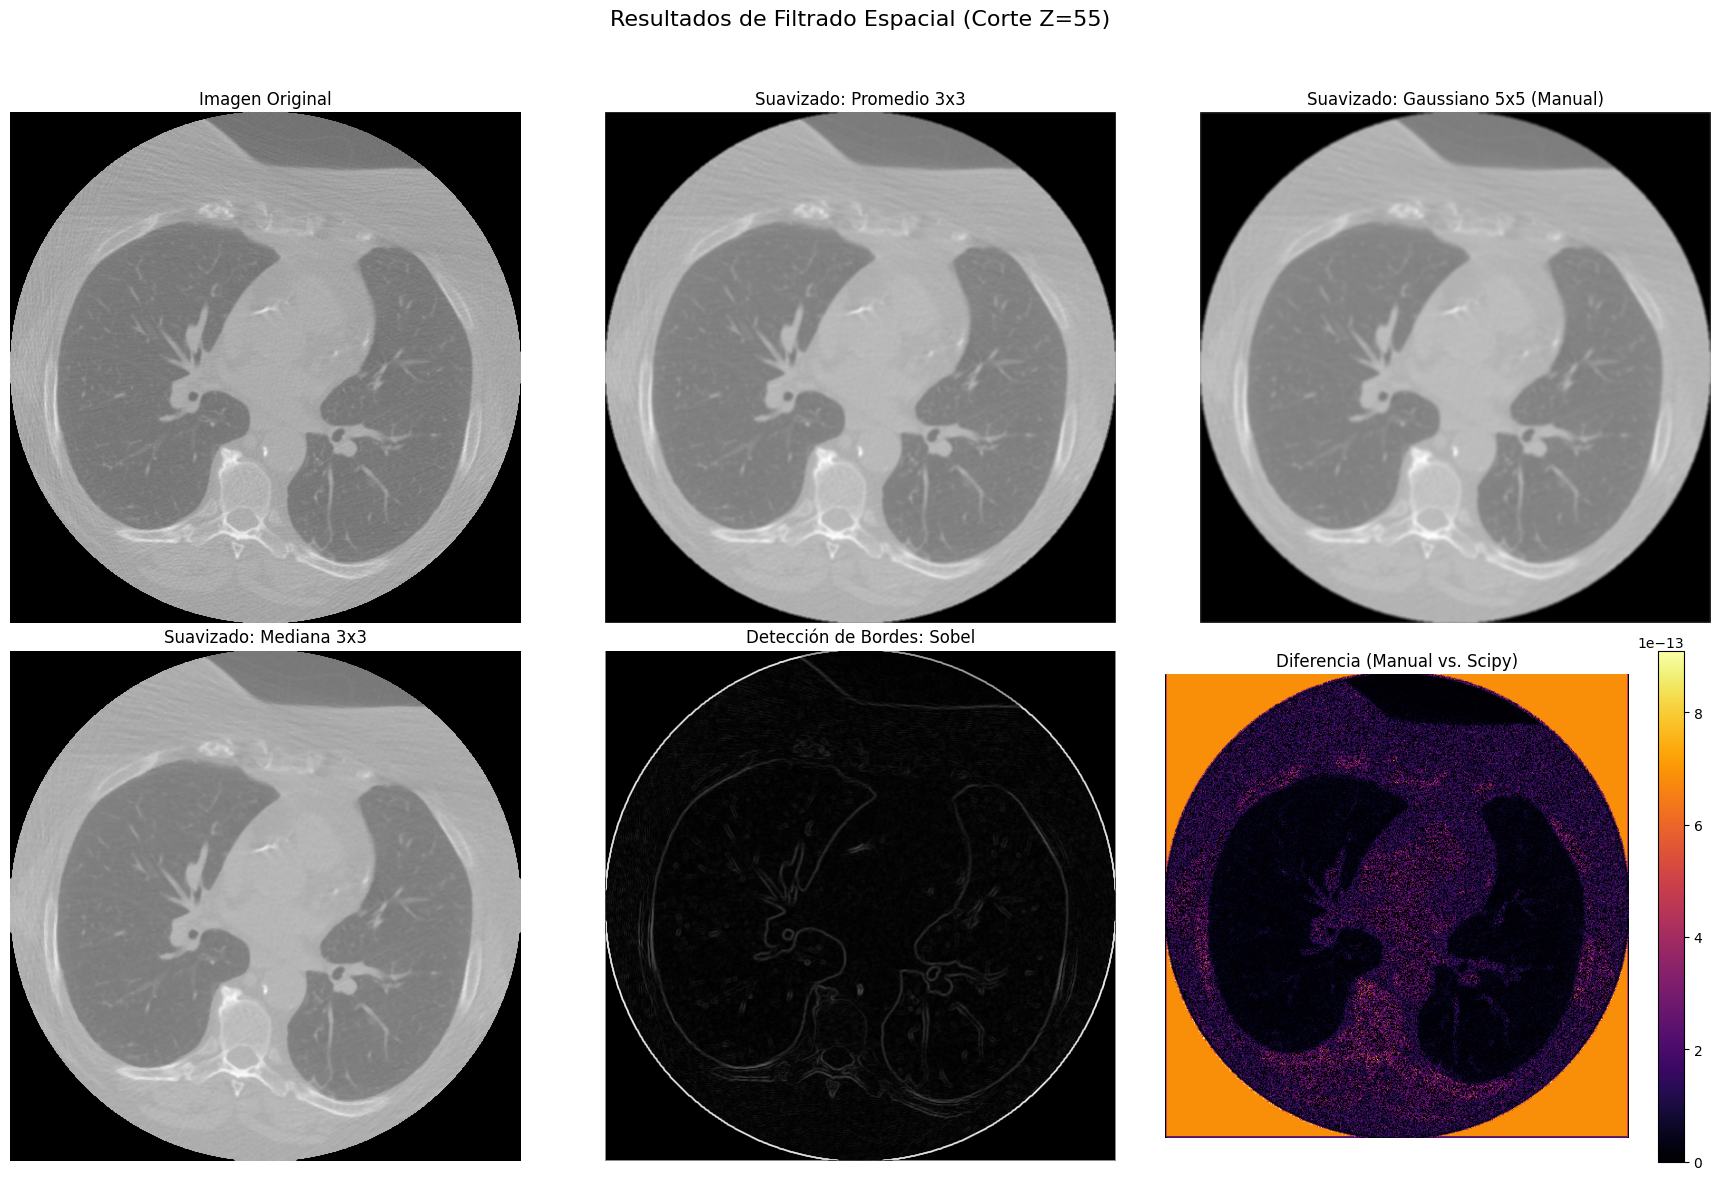


--- Herramienta para calcular SNR sobre la IMAGEN ORIGINAL ---


interactive(children=(IntSlider(value=150, description='Posición X:', max=502), IntSlider(value=150, descripti…

Output()

In [43]:
import ipywidgets as widgets

def cargar_volumen_dicom(directorio):
    """Carga una serie de archivos DICOM de un directorio y los apila en un volumen 3D."""
    try:
        archivos = [os.path.join(directorio, f) for f in os.listdir(directorio) if f.lower().endswith('.dcm')]
        datasets = [pydicom.dcmread(p) for p in archivos]
        datasets.sort(key=lambda ds: int(ds.InstanceNumber))
        volumen = np.stack([ds.pixel_array for ds in datasets])
        print(f"Volumen 3D de {volumen.shape} cargado correctamente.")
        return volumen
    except Exception as e:
        print(f"No se pudo cargar la serie DICOM: {e}")
        return None

# --- 3. IMPLEMENTACIÓN MANUAL DE FILTROS ---

def mi_convolve2d(imagen, kernel):
    """Implementación manual de convolución 2D para filtros lineales."""
    alto_k, ancho_k = kernel.shape
    alto_img, ancho_img = imagen.shape
    pad = (alto_k - 1) // 2
    imagen_padded = np.pad(imagen, pad, mode='constant')
    resultado = np.zeros_like(imagen, dtype=np.float64)
    kernel_volteado = np.flipud(np.fliplr(kernel))
    for y in range(alto_img):
        for x in range(ancho_img):
            region = imagen_padded[y:y + alto_k, x:x + ancho_k]
            resultado[y, x] = np.sum(region * kernel_volteado)
    return resultado

def crear_kernel_gaussiano(tamano, sigma=1.0):
    """Genera un kernel (filtro) Gaussiano 2D."""
    centro = tamano // 2
    kernel = np.zeros((tamano, tamano))
    for i in range(tamano):
        for j in range(tamano):
            dist_cuadrado = (i - centro)**2 + (j - centro)**2
            kernel[i, j] = np.exp(-dist_cuadrado / (2 * sigma**2))
    return kernel / kernel.sum()

def filtro_mediana_manual(imagen, tamano_kernel=3):
    """Implementación manual de filtro de mediana (no lineal)."""
    alto_img, ancho_img = imagen.shape
    pad = (tamano_kernel - 1) // 2
    imagen_padded = np.pad(imagen, pad, mode='reflect')
    resultado = np.zeros_like(imagen)
    for y in range(alto_img):
        for x in range(ancho_img):
            region = imagen_padded[y:y + tamano_kernel, x:x + tamano_kernel]
            resultado[y, x] = np.median(region)
    return resultado

def filtro_sobel_manual(imagen):
    """Implementación manual del filtro de Sobel para detectar bordes."""
    kernel_gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)
    kernel_gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float64)
    grad_x = mi_convolve2d(imagen, kernel_gx)
    grad_y = mi_convolve2d(imagen, kernel_gy)
    magnitud = np.sqrt(grad_x**2 + grad_y**2)
    return magnitud

volume_3d = cargar_volumen_dicom(data_dir_2)

if volume_3d is not None:
    idx_corte = volume_3d.shape[0] // 2
    imagen_original = volume_3d[idx_corte, :, :].astype(np.float64)
    
    # --- A. APLICAR FILTROS Y COMPARAR CON SCIPY ---
    print("\n--- Aplicando filtros y comparando con Scipy ---")
    
    kernel_promedio = np.ones((3, 3), dtype=np.float64) / 9.0
    kernel_gaussiano = crear_kernel_gaussiano(tamano=5, sigma=1.5)
    
    img_promedio = mi_convolve2d(imagen_original, kernel_promedio)
    img_gaussiano_manual = mi_convolve2d(imagen_original, kernel_gaussiano)
    img_mediana = filtro_mediana_manual(imagen_original, tamano_kernel=3)
    img_sobel = filtro_sobel_manual(imagen_original)
    
    # Comparación con Scipy usando el filtro Gaussiano
    img_gaussiano_scipy = scipy_convolve(imagen_original, kernel_gaussiano, mode='constant', cval=0.0)
    diferencia = np.abs(img_gaussiano_manual - img_gaussiano_scipy)
    print(f"Comparación Gaussiano Manual vs. Scipy:")
    print(f" -> Diferencia Máxima Absoluta: {np.max(diferencia):.4e}")
    print(f" -> Diferencia Media Absoluta:  {np.mean(diferencia):.4e}")

    # --- B. VISUALIZAR RESULTADOS ---
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'Resultados de Filtrado Espacial (Corte Z={idx_corte})', fontsize=16)
    
    axes[0, 0].imshow(imagen_original, cmap='gray'); axes[0, 0].set_title('Imagen Original')
    axes[0, 1].imshow(img_promedio, cmap='gray'); axes[0, 1].set_title('Suavizado: Promedio 3x3')
    axes[0, 2].imshow(img_gaussiano_manual, cmap='gray'); axes[0, 2].set_title('Suavizado: Gaussiano 5x5 (Manual)')
    axes[1, 0].imshow(img_mediana, cmap='gray'); axes[1, 0].set_title('Suavizado: Mediana 3x3')
    axes[1, 1].imshow(img_sobel, cmap='gray'); axes[1, 1].set_title('Detección de Bordes: Sobel')
    
    # Visualización de la diferencia
    im_diff = axes[1, 2].imshow(diferencia, cmap='inferno'); axes[1, 2].set_title('Diferencia (Manual vs. Scipy)')
    fig.colorbar(im_diff, ax=axes[1, 2])

    for ax in axes.ravel(): ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # --- C. HERRAMIENTA INTERACTIVA PARA CALCULAR SNR ---
    print("\n--- Herramienta para calcular SNR sobre la IMAGEN ORIGINAL ---")
    
    alto_img, ancho_img = imagen_original.shape
    output_area = widgets.Output()

    def update_roi_analysis(x, y, width, height):
        with output_area:
            output_area.clear_output(wait=True)
            fig, ax = plt.subplots(figsize=(7, 7))
            ax.imshow(imagen_original, cmap='gray')
            rect = plt.Rectangle((x, y), width, height, linewidth=2, edgecolor='cyan', facecolor='none')
            ax.add_patch(rect)
            roi = imagen_original[y:y+height, x:x+width]
            
            if roi.size > 0:
                media, dev_std = np.mean(roi), np.std(roi)
                snr = media / dev_std if dev_std > 0 else float('inf')
                title = f'ROI: μ={media:.2f}, σ={dev_std:.2f}, SNR={snr:.2f}'
            else: title = "Define un ROI válido"
            ax.set_title(title, fontsize=14)
            ax.axis('off')
            plt.show()

    controls = widgets.interactive(update_roi_analysis,
        x=widgets.IntSlider(min=0, max=ancho_img-10, value=150, description='Posición X:'),
        y=widgets.IntSlider(min=0, max=alto_img-10, value=150, description='Posición Y:'),
        width=widgets.IntSlider(min=10, max=ancho_img//2, value=50, description='Ancho:'),
        height=widgets.IntSlider(min=10, max=alto_img//2, value=50, description='Alto:')
    )
    
    display(controls, output_area)


## 3.2.2

--- Ejecutando la sección de Filtrado Combinado con SOBEL (Método Corregido) ---
Imagen './Tarea_1/datos/xray.dcm' cargada. Dimensiones: (1024, 1024)


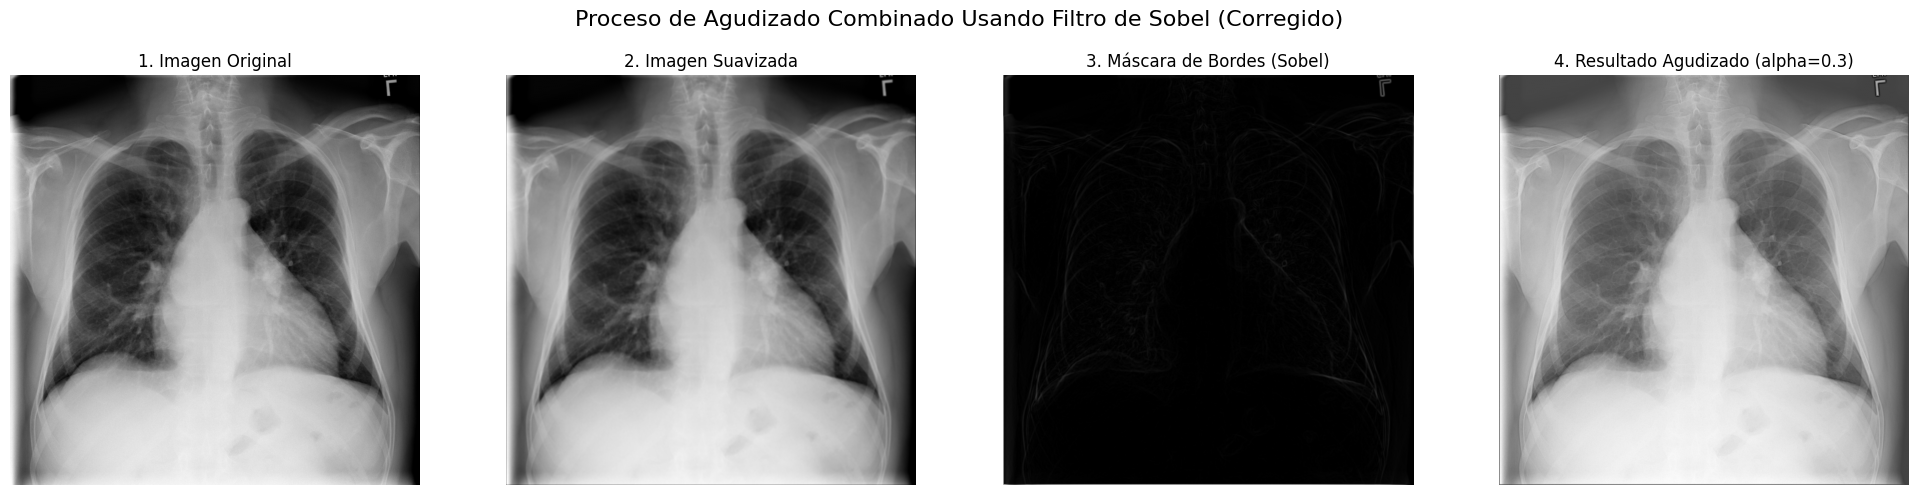

In [57]:
def mi_convolve2d(imagen, kernel):
    """Implementación manual de convolución 2D para filtros lineales."""
    alto_k, ancho_k = kernel.shape
    alto_img, ancho_img = imagen.shape
    pad = (alto_k - 1) // 2
    imagen_padded = np.pad(imagen, pad, mode='constant')
    resultado = np.zeros_like(imagen, dtype=np.float64)
    kernel_volteado = np.flipud(np.fliplr(kernel))
    for y in range(alto_img):
        for x in range(ancho_img):
            region = imagen_padded[y:y + alto_k, x:x + ancho_k]
            resultado[y, x] = np.sum(region * kernel_volteado)
    return resultado

def crear_kernel_gaussiano(tamano, sigma=1.0):
    """Genera un kernel (filtro) Gaussiano 2D."""
    centro = tamano // 2
    kernel = np.zeros((tamano, tamano))
    for i in range(tamano):
        for j in range(tamano):
            dist_cuadrado = (i - centro)**2 + (j - centro)**2
            kernel[i, j] = np.exp(-dist_cuadrado / (2 * sigma**2))
    return kernel / kernel.sum()

def filtro_sobel_manual(imagen):
    """Implementación manual del filtro de Sobel para detectar bordes."""
    kernel_gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float64)
    kernel_gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=np.float64)
    grad_x = mi_convolve2d(imagen, kernel_gx)
    grad_y = mi_convolve2d(imagen, kernel_gy)
    magnitud = np.sqrt(grad_x**2 + grad_y**2)
    return magnitud

# --- 3. EJECUCIÓN PRINCIPAL ---

print("--- Ejecutando la sección de Filtrado Combinado con SOBEL (Método Corregido) ---")

try:
    # Cargar la imagen de rayos X
    ds_xray = pydicom.dcmread(xray_filepath)
    img_original = ds_xray.pixel_array.astype(np.float64)
    print(f"Imagen '{xray_filepath}' cargada. Dimensiones: {img_original.shape}")

    kernel_suavizado_gauss = crear_kernel_gaussiano(tamano=5, sigma=1.5)
    
    # --- Proceso de Agudizado Combinado ---
    
    # PASO 1: Suavizar la imagen para reducir el ruido. (Sin cambios)
    img_suavizada = mi_convolve2d(img_original, kernel_suavizado_gauss)
    
    # PASO 2: Aplicar Sobel a la imagen suavizada para obtener la máscara de bordes. (Sin cambios)
    mascara_sobel = filtro_sobel_manual(img_suavizada)
    
    # PASO 3: Combinar la máscara con la imagen original usando un factor de ponderación 'alpha'.
    # ¡ESTE ES EL CAMBIO CLAVE!
    alpha = 0.3 # Factor de control. Puedes probar valores como 0.3, 0.5, 1.0
    img_agudizada_final = img_original - (alpha * mascara_sobel)

    # --- 4. VISUALIZACIÓN DEL PROCESO ---
    
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle('Proceso de Agudizado Combinado Usando Filtro de Sobel (Corregido)', fontsize=16)
    
    axes[0].imshow(img_original, cmap='gray'); axes[0].set_title('1. Imagen Original')
    axes[1].imshow(img_suavizada, cmap='gray'); axes[1].set_title('2. Imagen Suavizada')
    axes[2].imshow(mascara_sobel, cmap='gray'); axes[2].set_title('3. Máscara de Bordes (Sobel)')
    axes[3].imshow(img_agudizada_final, cmap='gray'); axes[3].set_title(f'4. Resultado Agudizado (alpha={alpha})')

    for ax in axes.ravel(): ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{xray_filepath}'.")


La aplicación combinada de filtros de suavizado y agudizado, según la sección 3.7 (página 169) del documento, busca realzar, mejorando detalles finos y bordes importantes mientras se controla el ruido. La pertinencia de los pasos es:

1.  **Cálculo del Laplaciano:** Se usa para resaltar detalles finos en la radiografía (texturas óseas, fisuras sutiles). Su desventaja es que también amplifica el ruido.
2.  **Cálculo del Gradiente (ej. Sobel):** Identifica los bordes más prominentes (contornos de huesos) con una menor amplificación de ruido en comparación con el Laplaciano.
3.  **Suavizado del Gradiente:** Reduce el ruido en la imagen del gradiente. Esto crea una "máscara" más limpia que solo representa las regiones de bordes significativos.
4.  **Producto del Laplaciano y Gradiente Suavizado:** Este paso es crucial. La máscara del gradiente suavizado modula la imagen Laplaciana. Así, el agudizado del Laplaciano se aplica con más fuerza en los bordes importantes (detectados por el gradiente) y se atenúa en regiones más planas (donde el Laplaciano principalmente realzaría ruido). Se combinan las fortalezas de ambos filtros.
5.  **Suma del resultado a la imagen original:** Integra las mejoras (detalles agudizados selectivamente) de nuevo en la imagen original, produciendo una imagen general más nítida.
6.  **Transformación de Intensidad (ej. Ley de Potencia):** Mejora el contraste general y expande el rango dinámico de la imagen agudizada. Esto es vital en radiografías para hacer visibles detalles sutiles en áreas que podrían ser demasiado oscuras o claras.

En resumen, este proceso permite un agudizado inteligente: se realzan los detalles importantes (mediante el Laplaciano en las zonas indicadas por el gradiente) y se definen mejor los bordes principales, todo mientras se intenta minimizar la amplificación de ruido y se mejora el contraste final para una mejor visualización diagnóstica de la `xray.dcm`.

## 3.2.3

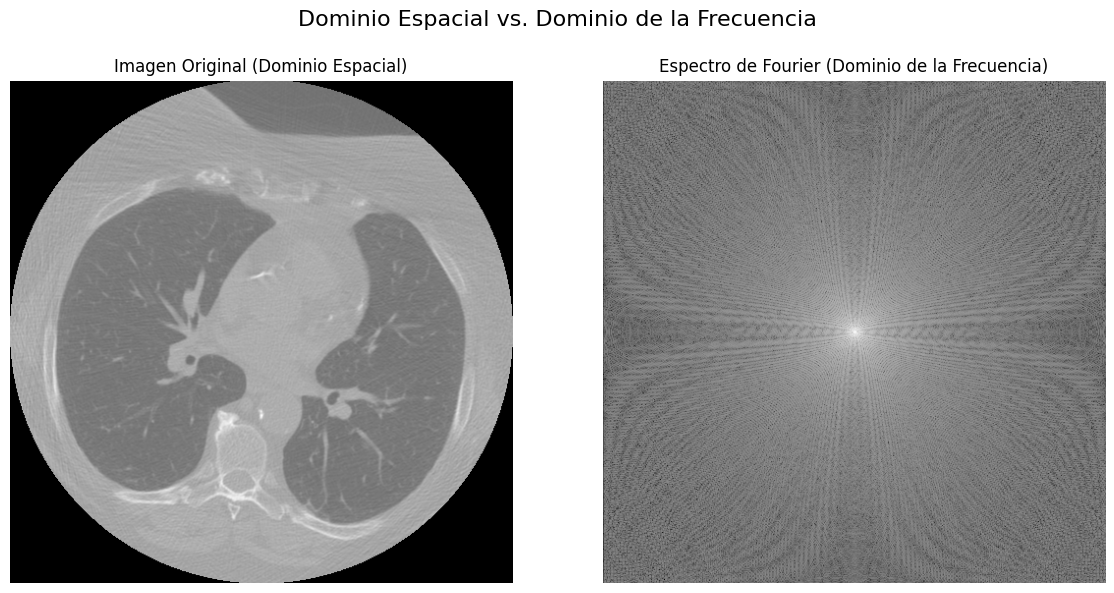

In [58]:
from numpy.fft import fft2, fftshift, ifft2

if 'imagen_original' not in locals():
    print("Error: La variable 'imagen_original' no fue encontrada.")
    print("Por favor, ejecuta las celdas anteriores para cargar los datos primero.")
else:
    # --- PASO 1.1: Calcular la Transformada de Fourier 2D ---
    # fft2 calcula la transformada de la imagen.
    f_transform = fft2(imagen_original)

    # --- PASO 1.2: Centrar el Espectro ---
    # Por defecto, la componente de frecuencia (0,0) (la componente DC) está en la esquina.
    # fftshift la mueve al centro de la imagen, que es como se visualiza convencionalmente.
    f_transform_shifted = fftshift(f_transform)

    # --- PASO 1.3: Calcular el Espectro de Magnitud para Visualización ---
    # La transformada es compleja. Para verla, calculamos su magnitud (valor absoluto).
    # Se aplica una escala logarítmica (log(1 + magnitud)) para comprimir el rango dinámico
    # y poder ver las componentes de alta frecuencia, que suelen ser muy débiles.
    magnitud_espectro = np.log(1 + np.abs(f_transform_shifted))

    # --- 3. VISUALIZACIÓN ---
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle('Dominio Espacial vs. Dominio de la Frecuencia', fontsize=16)
    
    axes[0].imshow(imagen_original, cmap='gray')
    axes[0].set_title('Imagen Original (Dominio Espacial)')
    axes[0].axis('off')
    
    axes[1].imshow(magnitud_espectro, cmap='gray')
    axes[1].set_title('Espectro de Fourier (Dominio de la Frecuencia)')
    axes[1].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Imagen Izquierda (Dominio Espacial): Es la imagen normal, tal como la vemos, donde cada punto representa la intensidad de un píxel.

Imagen Derecha (Dominio de la Frecuencia): Es el espectro de Fourier.
El centro brillante representa las bajas frecuencias (la componente DC o brillo promedio de la imagen). Corresponden a las áreas de cambio lento.
Los puntos más alejados del centro representan las altas frecuencias. Corresponden a los detalles finos, los bordes y el ruido.

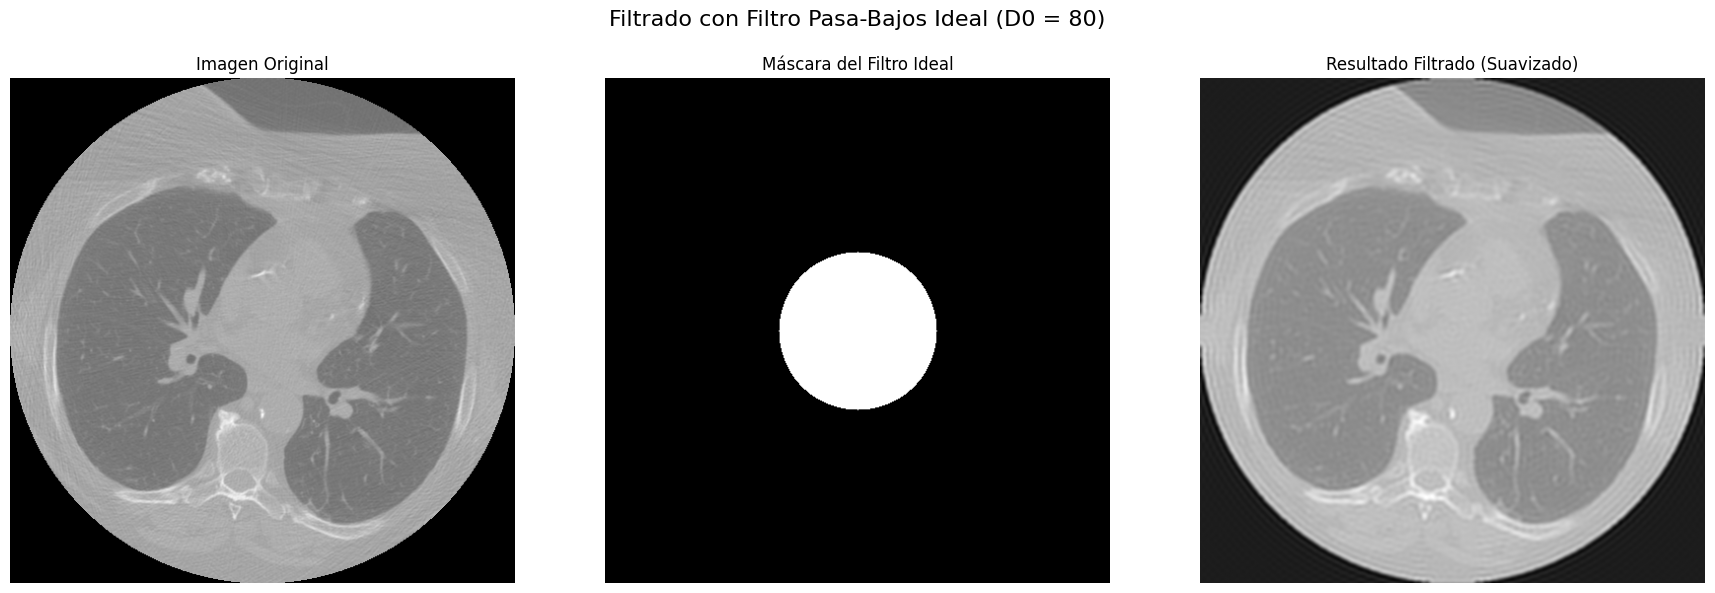

In [61]:
from numpy.fft import fft2, fftshift, ifftshift, ifft2


def crear_filtro_ideal_pasa_bajos(shape, D0):
    """
    Crea un filtro Pasa-Bajos Ideal centrado.
    shape: tupla con las dimensiones de la imagen (filas, columnas).
    D0: frecuencia de corte (el radio del círculo).
    """
    filas, columnas = shape
    centro_fila, centro_col = filas // 2, columnas // 2
    
    # Crear una grilla de coordenadas (x, y)
    x, y = np.ogrid[:filas, :columnas]
    
    # Calcular la distancia de cada punto al centro
    distancia_desde_centro = np.sqrt((x - centro_fila)**2 + (y - centro_col)**2)
    
    # Crear la máscara: 1 si la distancia <= D0, 0 en caso contrario.
    filtro = (distancia_desde_centro <= D0).astype(float)
    
    return filtro

# --- 3. EJECUCIÓN ---

if 'imagen_original' not in locals():
    print("Error: La variable 'imagen_original' no fue encontrada.")
else:
    # --- PASO 2.1: Calcular la FFT y centrarla (como en el paso anterior) ---
    f_transform = fft2(imagen_original)
    f_transform_shifted = fftshift(f_transform)

    # --- PASO 2.2: Diseñar el filtro ---
    # D0 es el radio de corte. Un valor más pequeño suaviza más.
    frecuencia_corte_D0 = 80 
    filtro_ilpf = crear_filtro_ideal_pasa_bajos(imagen_original.shape, frecuencia_corte_D0)

    # --- PASO 2.3: Aplicar el filtro en el dominio de la frecuencia ---
    # Multiplicamos el espectro de la imagen por el filtro.
    espectro_filtrado_shifted = f_transform_shifted * filtro_ilpf

    # --- PASO 2.4: Invertir la transformada para volver al dominio espacial ---
    # 1. Des-centrar el espectro
    espectro_filtrado = ifftshift(espectro_filtrado_shifted)
    # 2. Aplicar la Transformada Inversa de Fourier
    imagen_filtrada = ifft2(espectro_filtrado)
    # 3. Tomar la parte real del resultado (la parte imaginaria es muy pequeña)
    imagen_filtrada = np.real(imagen_filtrada)

    # --- 4. VISUALIZACIÓN ---
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'Filtrado con Filtro Pasa-Bajos Ideal (D0 = {frecuencia_corte_D0})', fontsize=16)
    
    axes[0].imshow(imagen_original, cmap='gray')
    axes[0].set_title('Imagen Original')
    
    axes[1].imshow(filtro_ilpf, cmap='gray')
    axes[1].set_title('Máscara del Filtro Ideal')
    
    axes[2].imshow(imagen_filtrada, cmap='gray')
    axes[2].set_title('Resultado Filtrado (Suavizado)')

    for ax in axes.ravel():
        ax.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Máscara del Filtro: Esta imagen muestra el filtro que hemos diseñado. Es un círculo blanco (valor 1) sobre un fondo negro (valor 0). Todo lo que esté en la zona blanca del espectro de Fourier "pasará", y todo lo que esté en la zona negra será eliminado.
Resultado Filtrado: La imagen resultante es una versión suavizada o borrosa de la original. Esto ocurre porque hemos eliminado las altas frecuencias, que son las responsables de los detalles finos y los bordes abruptos.

In [ ]:
Máscara del Filtro: Esta imagen muestra el filtro que hemos diseñado. Es un círculo blanco (valor 1) sobre un fondo negro (valor 0). Todo lo que esté en la zona blanca del espectro de Fourier "pasará", y todo lo que esté en la zona negra será eliminado.
Resultado Filtrado: La imagen resultante es una versión suavizada o borrosa de la original. Esto ocurre porque hemos eliminado las altas frecuencias, que son las Aresponsables de los detalles finos y los bordes abruptos.

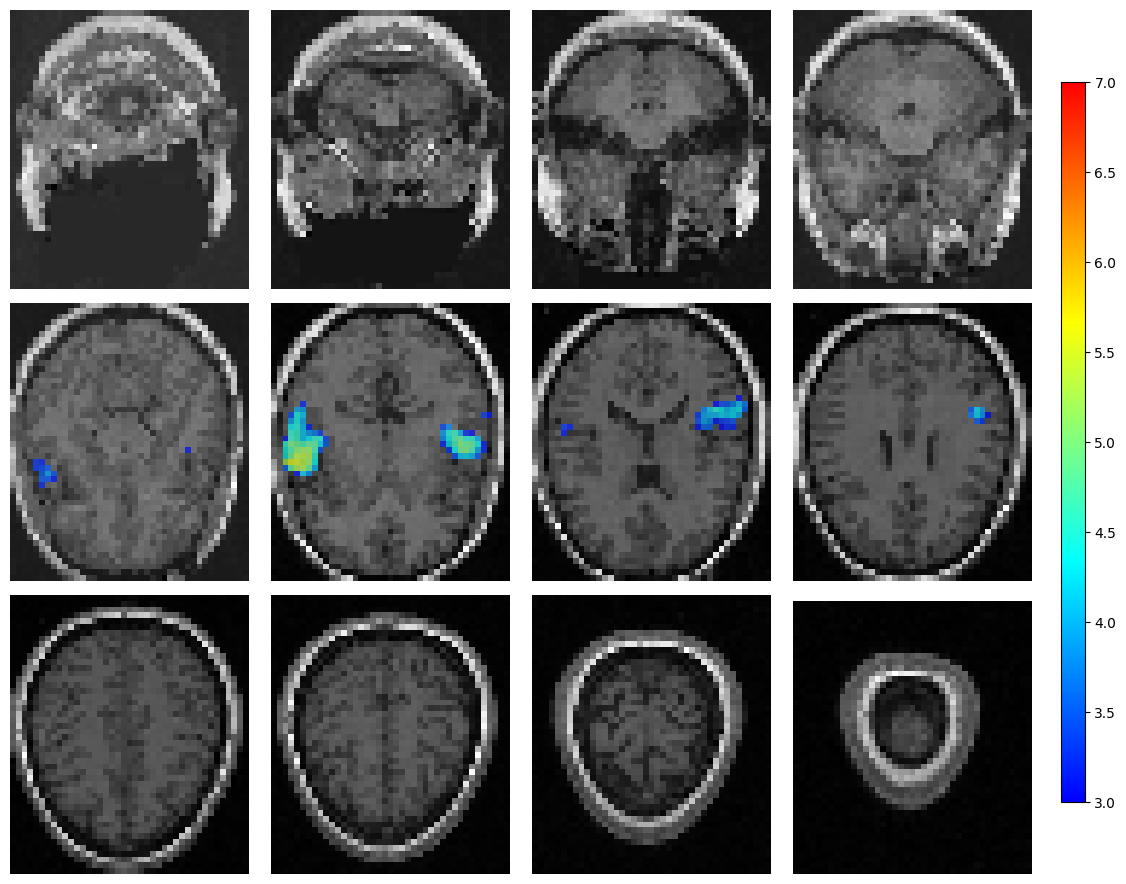

In [46]:
# Cargar los datos
anat = nib.load('./Tarea_1/datos/anat.nii').get_fdata()
zmap_voice = nib.load('./Tarea_1/datos/zmap_voice.nii').get_fdata()
zmap_nonvoice = nib.load('./Tarea_1/datos/zmap_nonvoice.nii').get_fdata()

# Combinar las activaciones (tomar el máximo entre voice y nonvoice)
combined_zmap = np.maximum(zmap_voice, zmap_nonvoice)

# Crear un mapa de colores personalizado (azul-cian-amarillo-rojo)
colors = [(0, 0, 1), (0, 1, 1), (1, 1, 0), (1, 0, 0)]  # Azul, Cian, Amarillo, Rojo
cmap = mcolors.LinearSegmentedColormap.from_list('activation', colors)

# Selección de rebanadas axiales (12 rebanadas en total)
n_slices = 12
z_size = anat.shape[2]
slice_indices = np.linspace(0, z_size - 1, n_slices).astype(int)

# Crear figura con rejilla 3x4
fig, axes = plt.subplots(3, 4, figsize=(12, 9))
axes = axes.flatten()

# Graficar cada rebanada
for i, ax in enumerate(axes):
    idx = slice_indices[i]
    # Rebanada anatómica (transponer para orientación correcta)
    anat_slice = anat[:, :, idx].T
    # Rebanada de activación (transponer para orientación correcta)
    zmap_slice = combined_zmap[:, :, idx].T
    
    # Mostrar imagen anatómica en escala de grises
    ax.imshow(anat_slice, cmap='gray')
    
    # Overlay de la activación (máscara para valores >=3)
    masked_zmap = np.ma.masked_less(zmap_slice, 0.03)
    ax.imshow(masked_zmap, cmap=cmap, alpha=0.7, vmin=0.03, vmax=0.07)
    
    # Ocultar ejes
    ax.axis('off')

# Ajustar distribución de la figura
plt.subplots_adjust(left=0.02, right=0.88, bottom=0.02, top=0.98, wspace=0.05, hspace=0.05)

# Agregar barra de colores
cax = fig.add_axes([0.9, 0.1, 0.02, 0.8])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=3, vmax=7))
sm.set_array([])
fig.colorbar(sm, cax=cax)

plt.show()

no me funciona :(